# Lauch Kilosort4 GUI
C:\Users\invibad\anaconda3\Scripts\activate.bat
conda activate spikeinterface_env
python -m kilosort

# Lauch Phy
C:\Users\invibad\anaconda3\Scripts\activate.bat
conda activate phy_env
phy template-gui  D:\Data_Mice\VF069_2025_12_06\KS\sorter_output\params.py

In [3]:
# IMPORTS
from pathlib import Path
from spikeinterface.sorters import run_sorter, get_default_sorter_params
import spikeinterface.full as si
import os
from mtscomp import compress
from spikeinterface.extractors import read_spikeglx
from spikeinterface.preprocessing import (
    highpass_filter,
    phase_shift,
    detect_bad_channels,
    interpolate_bad_channels,
    highpass_spatial_filter
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
from sklearn.linear_model import LinearRegression
from scipy.signal import correlate

c:\Users\invibad\anaconda3\envs\spikeinterface_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from pathlib import Path

DATA_ROOT = Path(r"D:\Data_Mice")
DB_PATH   = DATA_ROOT / "full_db_all_rigs.feather"

MOUSE_LIST = ["VF066_2025_12_05"]

def build_paths(session_name: str, data_root: Path = DATA_ROOT) -> dict:
    base_folder = data_root / session_name

    rec_root = base_folder / "Rec"
    ks_root  = base_folder / "KS"
    alf_root = base_folder / "alf"
    shift_path = base_folder / "shift.txt"

    # probes présentes (toujours probe00, probe01 optionnelle)
    if not (rec_root / "probe00").is_dir():
        raise FileNotFoundError(f"[{session_name}] Missing folder: {rec_root / 'probe00'}")

    present_probes = ["probe00"] + (["probe01"] if (rec_root / "probe01").is_dir() else [])
    multi_probe = (len(present_probes) == 2)

    # dict par probe
    probes = {}
    for p in present_probes:
        rec_folder = rec_root / p
        ks_folder  = ks_root  / p
        alf_folder = alf_root / p

        ks_folder.mkdir(parents=True, exist_ok=True)
        alf_folder.mkdir(parents=True, exist_ok=True)

        probes[p] = {
            "rec_folder": rec_folder,
            "ks_folder": ks_folder,
            "alf_folder": alf_folder,
            "recording_json": ks_folder / "recording.json",
            "sorting_json":   ks_folder / "sorting.json",
            "output_folder":  ks_folder,
        }

    # compat: anciennes clés -> probe00 (pour ne rien casser)
    p0 = probes["probe00"]

    return {
        "session_name": session_name,
        "base_folder": base_folder,

        # compat (pipeline existant)
        "rec_folder": p0["rec_folder"],
        "ks_folder": p0["ks_folder"],
        "alf_folder": p0["alf_folder"],
        "shift_path": shift_path,
        "recording_json": p0["recording_json"],
        "sorting_json": p0["sorting_json"],
        "output_folder": p0["output_folder"],
        "db_path": DB_PATH,

        # multi-probe
        "present_probes": present_probes,
        "multi_probe": multi_probe,
        "probes": probes,
    }

SESSIONS = [build_paths(name) for name in MOUSE_LIST]


In [7]:
## LOADING RECORDINGS

for sess in SESSIONS:
    print(f"\n=== Loading recording: {sess['session_name']} ===")

    sess["recordings"] = {}

    for probe, P in sess["probes"].items():
        probe_idx = int(probe.replace("probe", ""))   # probe00 -> 0, probe01 -> 1
        stream_name = f"imec{probe_idx}.ap"

        print(f"  -> loading {probe} ({stream_name})")

        recording_processed = read_spikeglx(
            P["rec_folder"],
            stream_name=stream_name
        )

        sess["recordings"][probe] = recording_processed

    # compat mono-probe
    sess["recording"] = sess["recordings"]["probe00"]


=== Loading recording: VF066_2025_12_05 ===
  -> loading probe00 (imec0.ap)
  -> loading probe01 (imec1.ap)


In [8]:
# SORTING KILOSORT4

# params (une fois pour toutes)
params = get_default_sorter_params("kilosort4")

for sess in SESSIONS:
    print(f"\n=== Kilosort4: {sess['session_name']} ===")

    # Compat: si l'ancienne clé existe, on peut encore tourner (mais normalement on a sess["recordings"])
    recordings = sess.get("recordings", None)
    if recordings is None:
        rec0 = sess.get("recording", None)
        if rec0 is None:
            print("  [SKIP] No recording found in sess['recordings'] or sess['recording'].")
            continue
        recordings = {"probe00": rec0}

    sess["sortings"] = {}

    for probe, recording in recordings.items():
        print(f"  -> running on {probe}")

        P = sess["probes"].get(probe, None)
        if P is None:
            print(f"  [SKIP] Missing sess['probes'][{probe}] paths.")
            continue

        ks_folder = Path(P["ks_folder"])
        ks_folder.mkdir(parents=True, exist_ok=True)

        try:
            sorting = run_sorter(
                sorter_name="kilosort4",
                recording=recording,
                folder=ks_folder,
                remove_existing_folder=True,
                verbose=True,
                **params
            )

            # save dumps (SpikeInterface JSON dumps)
            recording.dump(ks_folder / "recording.json")
            sorting.dump(ks_folder / "sorting.json")

            # store per-probe
            sess["sortings"][probe] = sorting
            P["recording_json"] = ks_folder / "recording.json"
            P["sorting_json"]   = ks_folder / "sorting.json"

            print(f"  [OK] {probe}: Sorting + dumps saved.")

        except Exception as e:
            print(f"  [ERROR] {sess['session_name']} {probe} failed: {type(e).__name__}: {e}")
            sess.setdefault("error_sorting", {})
            sess["error_sorting"][probe] = f"{type(e).__name__}: {e}"

    # compat: anciennes clés -> probe00 (si dispo)
    if "probe00" in sess["sortings"]:
        sess["sorting"] = sess["sortings"]["probe00"]
        sess["recording_json"] = sess["probes"]["probe00"]["recording_json"]
        sess["sorting_json"]   = sess["probes"]["probe00"]["sorting_json"]




=== Kilosort4: VF066_2025_12_05 ===
  -> running on probe00


write_binary_recording (no parallelization): 100%|██████████| 4195/4195 [08:24<00:00,  8.32it/s]
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 125846005
kilosort.run_kilosort: N seconds: 4194.8668333333335
kilosort.run_kilosort: N batches: 2098
kilosort.run_kilosort: Preprocessing filters computed in  25.24s; total  25.32s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     3.10 %
kilosort.run_kilosort: Memory:       40.75 %     |     12.92   /    31.71 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   23.04 %     |      2.76   /    11.99 GB
kilosort.run_kilosort: All

kilosort4 run time 7759.44s
  [OK] probe00: Sorting + dumps saved.
  -> running on probe01


write_binary_recording (no parallelization): 100%|██████████| 4195/4195 [07:48<00:00,  8.96it/s]
kilosort.run_kilosort:  
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 125846017
kilosort.run_kilosort: N samples: 125846017
kilosort.run_kilosort: N seconds: 4194.867233333333
kilosort.run_kilosort: N seconds: 4194.867233333333
kilosort.run_kilosort: N batches: 2098
kilosort.run_kilosort: N batches: 2098
kilosort.run_kilosort: Preprocessing filters computed in  10.16s; total  10.16s
kilosort.run_kilosort: Preprocessing filters computed in  10.16s; total  10.16s
kilosort.run_kilosort:  
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_

kilosort4 run time 7592.65s
  [OK] probe01: Sorting + dumps saved.


In [9]:
# CONVERSION ALF FORMAT

from pathlib import Path
from atlaselectrophysiology.extract_files import extract_data

# --- optionnel : si tu veux arrêter au premier problème ---
STOP_ON_ERROR = False

for s in SESSIONS:
    session = s["session_name"]

    # compat : si pas de multi-probe dict, on fait comme avant
    probes = s.get("probes", None)
    if probes is None:
        probes = {"probe00": {"rec_folder": s["rec_folder"], "ks_folder": s["ks_folder"], "alf_folder": s["alf_folder"]}}

    for probe, P in probes.items():
        rec_folder = Path(P["rec_folder"])
        ks_folder  = Path(P["ks_folder"])
        alf_folder = Path(P["alf_folder"])

        tag = f"{session}/{probe}"

        # --- checks de base ---
        if not rec_folder.exists():
            msg = f"[{tag}] ❌ rec_folder introuvable: {rec_folder}"
            if STOP_ON_ERROR:
                raise FileNotFoundError(msg)
            print(msg)
            continue

        # Selon ton organisation, le sorting est souvent dans KS/sorter_output
        sorter_output = ks_folder / "sorter_output"
        ks_input = sorter_output if sorter_output.exists() else ks_folder

        if not ks_input.exists():
            msg = f"[{tag}] ❌ ks_folder introuvable: {ks_input}"
            if STOP_ON_ERROR:
                raise FileNotFoundError(msg)
            print(msg)
            continue

        alf_folder.mkdir(parents=True, exist_ok=True)

        print(f"\n[{tag}] Export ALF…")
        print(f"  ks_input   : {ks_input}")
        print(f"  rec_folder : {rec_folder}")
        print(f"  alf_folder : {alf_folder}")

        try:
            # IBL atlas GUI expects ALF outputs in alf_folder
            extract_data(ks_input, rec_folder, alf_folder)
            print(f"[{tag}] ✅ Export ALF terminé")
        except Exception as e:
            msg = f"[{tag}] ❌ Export ALF échoué: {type(e).__name__}: {e}"
            if STOP_ON_ERROR:
                raise
            print(msg)



[VF066_2025_12_05/probe00] Export ALF…
  ks_input   : D:\Data_Mice\VF066_2025_12_05\KS\probe00\sorter_output
  rec_folder : D:\Data_Mice\VF066_2025_12_05\Rec\probe00
  alf_folder : D:\Data_Mice\VF066_2025_12_05\alf\probe00


c:\Users\invibad\anaconda3\envs\spikeinterface_env\lib\site-packages\phylib\io\model.py:1090: RuntimeWarning: invalid value encountered in divide
  spikes_depths[ispi] = (np.sum(np.transpose(ypos * features) /
Extracting waveforms: 100%|██████████| 4205.790933333334/4205.790933333334 [01:58<00:00, 35.56it/s]
Converting to ALF: 155it [02:24,  1.07it/s]                         


2026-01-12 21:15:59 INFO     extract_files.py:82   Computing QC for D:\Data_Mice\VF066_2025_12_05\Rec\probe00\disabled_g0_t0.imec0.ap.bin


38880it [36:10, 17.92it/s]                       


2026-01-12 21:52:11 INFO     extract_files.py:82   Computing QC for D:\Data_Mice\VF066_2025_12_05\Rec\probe00\disabled_g0_t0.imec0.lf.bin


48450it [04:21, 185.16it/s]                        


[VF066_2025_12_05/probe00] ✅ Export ALF terminé

[VF066_2025_12_05/probe01] Export ALF…
  ks_input   : D:\Data_Mice\VF066_2025_12_05\KS\probe01\sorter_output
  rec_folder : D:\Data_Mice\VF066_2025_12_05\Rec\probe01
  alf_folder : D:\Data_Mice\VF066_2025_12_05\alf\probe01


c:\Users\invibad\anaconda3\envs\spikeinterface_env\lib\site-packages\phylib\io\model.py:1090: RuntimeWarning: invalid value encountered in divide
  spikes_depths[ispi] = (np.sum(np.transpose(ypos * features) /
Extracting waveforms: 100%|██████████| 4205.791366666666/4205.791366666666 [01:26<00:00, 48.65it/s]
Converting to ALF: 155it [01:41,  1.53it/s]                         


2026-01-12 21:58:46 INFO     extract_files.py:82   Computing QC for D:\Data_Mice\VF066_2025_12_05\Rec\probe01\disabled_g0_t0.imec1.ap.bin


38880it [36:24, 17.80it/s]                       


2026-01-12 22:35:12 INFO     extract_files.py:82   Computing QC for D:\Data_Mice\VF066_2025_12_05\Rec\probe01\disabled_g0_t0.imec1.lf.bin


48450it [04:30, 179.09it/s]                        


[VF066_2025_12_05/probe01] ✅ Export ALF terminé


In [13]:
import numpy as np
import matplotlib
matplotlib.use("Agg")  # pas d'affichage notebook
import matplotlib.pyplot as plt

from pathlib import Path
import sys

from PyQt5.QtWidgets import (
    QApplication, QWidget, QScrollArea,
    QLabel, QVBoxLayout, QHBoxLayout, QGridLayout,
    QTabWidget
)
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg


# ============================================================
# SESSION
# ============================================================
SESSION_ID = "VF066_2025_12_05"   # <-- mets ici ton ID
DATA_ROOT = Path(r"D:\Data_Mice")

base_folder = DATA_ROOT / SESSION_ID
mouse_name = base_folder.name

rec_root = base_folder / "Rec"
alf_root = base_folder / "alf"

# probes présentes (probe00 obligatoire, probe01 optionnelle)
if not (rec_root / "probe00").exists():
    raise FileNotFoundError(f"Missing folder: {rec_root / 'probe00'}")

present_probes = ["probe00"]
if (rec_root / "probe01").exists():
    present_probes.append("probe01")


# ============================================================
# PARAMÈTRES
# ============================================================
dtype = np.int16
fs = 30000

pre = 20
post = 40
window = pre + post

# IMPORTANT: Neuropixels = 384 canaux data + 1 canal sync => 385 dans le .bin
num_channels_bin = 385
sync_chan = num_channels_bin - 1  # dernier canal


# ============================================================
# SEUILS RÉGLABLES (TES "2 CRITÈRES")
# ============================================================
MC_THRESH = 0     # max_confidence >= MC_THRESH
NC_THRESH = 100   # noise_cutoff <  NC_THRESH


# ============================================================
# HELPERS
# ============================================================
def fmt(x, nd=2):
    if x is None:
        return "NA"
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return "NA"

def fmt_uv(x):
    # IMPORTANT: dans ton CSV, amp_median est déjà en µV
    if x is None:
        return "NA"
    try:
        return f"{float(x):.1f} µV"
    except Exception:
        return "NA"


# ============================================================
# CHARGEMENT PAR PROBE
# ============================================================
def load_probe_data(probe: str) -> dict:
    rec_folder = rec_root / probe
    alf_folder = alf_root / probe

    # bin file (SpikeGLX: imec0/imec1 dépend du probe index)
    probe_idx = int(probe.replace("probe", ""))  # probe00->0, probe01->1
    bin_file = rec_folder / f"disabled_g0_t0.imec{probe_idx}.ap.bin"

    # ALF spikes
    spike_times_file    = alf_folder / "spikes.times.npy"
    spike_clusters_file = alf_folder / "spikes.clusters.npy"
    spike_samples_file  = alf_folder / "spikes.samples.npy"   # optionnel
    spike_depths_file   = alf_folder / "spikes.depths.npy"

    # Metrics (ALF)
    metrics_candidates = [
        alf_folder / "cluster_metrics.csv",
        alf_folder / "clusters.metrics.csv",
        alf_folder / "clusters.metrics.tsv",
    ]
    cluster_metrics_file = next((p for p in metrics_candidates if p.exists()), None)

    # --- checks files ---
    required = [bin_file, spike_times_file, spike_clusters_file, spike_depths_file]
    for p in required:
        if not p.exists():
            raise FileNotFoundError(f"[{mouse_name}/{probe}] Missing file: {p}")

    if cluster_metrics_file is None:
        raise FileNotFoundError(
            f"[{mouse_name}/{probe}] Missing metrics file in ALF. Tried: "
            + ", ".join([str(p.name) for p in metrics_candidates])
        )

    # --- LOAD SPIKES (ALF) ---
    spike_times    = np.load(spike_times_file)
    spike_clusters = np.load(spike_clusters_file).astype(int)
    spike_depths   = np.load(spike_depths_file).astype(float)
    all_clusters   = np.unique(spike_clusters)

    if spike_samples_file.exists():
        spike_samples = np.load(spike_samples_file).astype(int)
    else:
        spike_samples = None

    # --- LOAD BIN (waveforms) ---
    data = np.memmap(bin_file, dtype=dtype, mode="r")
    if data.size % num_channels_bin != 0:
        raise RuntimeError(
            f"[{mouse_name}/{probe}] Incohérence: data.size={data.size} n'est pas divisible par num_channels_bin={num_channels_bin}."
        )
    total_samples = data.size // num_channels_bin
    data = data.reshape((total_samples, num_channels_bin))

    # --- LOAD METRICS (ALF) ---
    delimiter = "\t" if cluster_metrics_file.suffix.lower() == ".tsv" else ","
    metrics = np.genfromtxt(
        cluster_metrics_file,
        delimiter=delimiter,
        names=True,
        dtype=None,
        encoding="utf-8"
    )

    cols = metrics.dtype.names
    if cols is None:
        raise RuntimeError(f"[{mouse_name}/{probe}] Impossible de lire l'en-tête de {cluster_metrics_file.name}")

    cluster_id_col = "cluster_id" if "cluster_id" in cols else ("cluster_ids" if "cluster_ids" in cols else None)
    if cluster_id_col is None:
        raise KeyError(f"[{mouse_name}/{probe}] Colonne cluster_id/cluster_ids absente. Colonnes: {list(cols)}")

    needed = ["max_confidence", "noise_cutoff", "amp_median"]
    missing = [c for c in needed if c not in cols]
    if missing:
        raise KeyError(f"[{mouse_name}/{probe}] Colonnes manquantes dans {cluster_metrics_file.name}: {missing}. Colonnes: {list(cols)}")

    # map cid -> row
    ibl_map = {}
    for i in range(len(metrics)):
        cid = int(metrics[cluster_id_col][i])
        ibl_map[cid] = {c: metrics[c][i] for c in cols}

    # --- SELECTION: 2 critères ---
    clusters_selected = []
    for cid, row in ibl_map.items():
        try:
            mc = float(row["max_confidence"])
            nc = float(row["noise_cutoff"])
        except Exception:
            continue
        if (mc >= MC_THRESH) and (nc < NC_THRESH):
            clusters_selected.append(int(cid))

    all_set = set(all_clusters.tolist())
    clusters_selected = [cid for cid in clusters_selected if cid in all_set]
    clusters_selected.sort()

    return dict(
        probe=probe,
        rec_folder=rec_folder,
        alf_folder=alf_folder,
        bin_file=bin_file,
        cluster_metrics_file=cluster_metrics_file,
        spike_times=spike_times,
        spike_clusters=spike_clusters,
        spike_samples=spike_samples,
        spike_depths=spike_depths,
        all_clusters=all_clusters,
        clusters_selected=clusters_selected,
        ibl_map=ibl_map,
        data=data,
        total_samples=total_samples,
    )


def get_metrics_for_cluster(ctx: dict, cid: int):
    row = ctx["ibl_map"].get(int(cid), {})
    mc = row.get("max_confidence", None)
    nc = row.get("noise_cutoff", None)
    amp = row.get("amp_median", None)
    return mc, nc, amp


# ============================================================
# WAVEFORM PANEL (par probe)
# ============================================================
def make_cluster_block(ctx: dict, cid: int):
    spike_clusters = ctx["spike_clusters"]
    spike_times    = ctx["spike_times"]
    spike_samples  = ctx["spike_samples"]
    spike_depths   = ctx["spike_depths"]
    data           = ctx["data"]
    total_samples  = ctx["total_samples"]
    probe          = ctx["probe"]

    block = QWidget()
    block.setMinimumHeight(340)

    layout = QHBoxLayout(block)
    layout.setContentsMargins(12, 8, 12, 8)
    layout.setSpacing(35)

    idx = np.where(spike_clusters == cid)[0]
    if idx.size == 0:
        return None

    idx_small = idx[:120]

    d = spike_depths[idx]
    d = d[np.isfinite(d)]
    cluster_depth = float(np.median(d)) if d.size else np.nan

    if spike_samples is not None:
        st_small = spike_samples[idx_small]
    else:
        st_small = (spike_times[idx_small] * fs).astype(int)

    tmp = []
    for s in st_small[:40]:
        if pre < s < total_samples - post:
            tmp.append(data[s - pre:s + post, :])
    if len(tmp) == 0:
        return None

    tmp = np.array(tmp)
    ptp = tmp.ptp(axis=1).mean(axis=0)

    ptp[sync_chan] = -np.inf
    best_chan = int(np.argmax(ptp))

    wfs = []
    for s in st_small:
        if pre < s < total_samples - post:
            wfs.append(data[s - pre:s + post, best_chan])
    if len(wfs) == 0:
        return None

    wfs = np.array(wfs)
    wf_avg = wfs.mean(axis=0)

    t_ms = np.arange(window) / fs * 1000
    fig, ax = plt.subplots(figsize=(6, 4.8))
    for wf in wfs:
        ax.plot(t_ms, wf, color="black", alpha=0.10)
    ax.plot(t_ms, wf_avg, color="red", linewidth=1.6)

    ax.set_title(f"{probe} — Cluster {cid}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout(pad=0.8)

    canvas = FigureCanvasQTAgg(fig)

    mc, nc, amp = get_metrics_for_cluster(ctx, cid)

    info = QLabel(
        f"""
<b>{probe} — Cluster {cid}</b><br><br>
N spikes : {idx.size}<br>
Depth : {fmt(cluster_depth, nd=1)} µm<br><br>
max_confidence : {fmt(mc, nd=1)} (≥ {MC_THRESH:g})<br>
noise_cutoff : {fmt(nc, nd=2)} (&lt; {NC_THRESH:g})<br>
amp_median : {fmt_uv(amp)}<br>
"""
    )
    info.setAlignment(Qt.AlignTop)
    info.setStyleSheet("font-size:12px; padding:10px;")

    layout.addWidget(canvas)
    layout.addWidget(info)

    return block


# ============================================================
# VUE PAR PROBE (un onglet)
# ============================================================
class ProbeTab(QWidget):
    def __init__(self, ctx: dict):
        super().__init__()
        self.ctx = ctx

        main_layout = QVBoxLayout(self)

        header = QLabel(
            f"<h2>{mouse_name} — {ctx['probe']}</h2>"
            f"Clusters totaux : {len(ctx['all_clusters'])} — "
            f"Affichés (2 critères réglables) : {len(ctx['clusters_selected'])}<br>"
            f"Filtres : max_confidence ≥ {MC_THRESH:g} ; noise_cutoff &lt; {NC_THRESH:g}<br>"
            f"QC source: {ctx['cluster_metrics_file']}"
        )
        header.setStyleSheet("padding: 14px; font-size: 15px;")
        main_layout.addWidget(header)

        scroll = QScrollArea()
        scroll.setWidgetResizable(True)
        main_layout.addWidget(scroll)

        container = QWidget()
        scroll.setWidget(container)

        grid = QGridLayout(container)
        grid.setContentsMargins(15, 15, 15, 15)
        grid.setHorizontalSpacing(45)
        grid.setVerticalSpacing(50)

        col = 0
        row = 0

        for cid in ctx["clusters_selected"]:
            block = make_cluster_block(ctx, int(cid))
            if block is None:
                continue

            grid.addWidget(block, row, col)

            col += 1
            if col >= 2:
                col = 0
                row += 1


# ============================================================
# DASHBOARD (tabs)
# ============================================================
class Dashboard(QWidget):
    def __init__(self, probe_contexts: dict):
        super().__init__()

        self.setWindowTitle(f"Cluster Dashboard – {mouse_name}")
        self.resize(1600, 1050)

        layout = QVBoxLayout(self)

        tabs = QTabWidget()
        layout.addWidget(tabs)

        for probe, ctx in probe_contexts.items():
            tabs.addTab(ProbeTab(ctx), probe)


# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    # charge toutes les probes présentes
    probe_contexts = {}
    for probe in present_probes:
        probe_contexts[probe] = load_probe_data(probe)

    app = QApplication(sys.argv)
    w = Dashboard(probe_contexts)
    w.show()
    sys.exit(app.exec_())

SystemExit: 0

c:\Users\invibad\anaconda3\envs\spikeinterface_env\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


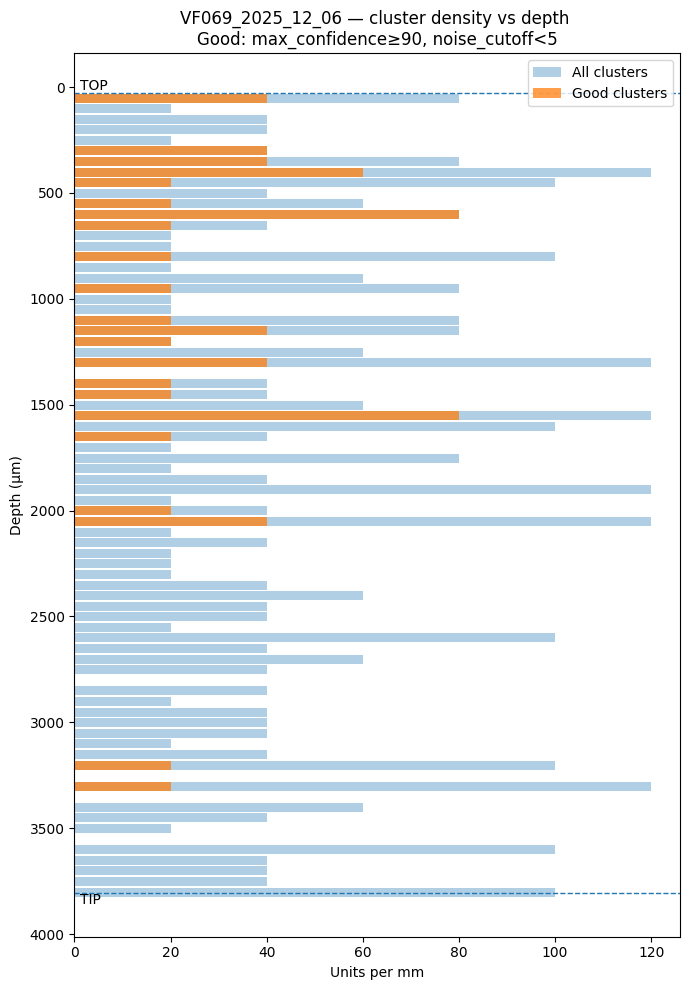

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# PATHS
# =========================
SESSION_ID = "VF069_2025_12_06"
DATA_ROOT = Path(r"D:\Data_Mice")

base_folder = DATA_ROOT / SESSION_ID
alf_folder = base_folder / "alf"

cluster_metrics_file = alf_folder / "cluster_metrics.csv"
spikes_depths_file   = alf_folder / "spikes.depths.npy"
spikes_clusters_file = alf_folder / "spikes.clusters.npy"

# =========================
# THRESHOLDS (tes 2 critères)
# =========================
MC_THRESH = 90.0
NC_THRESH = 5.0

# =========================
# LOAD cluster_metrics.csv
# =========================
metrics = np.genfromtxt(
    cluster_metrics_file,
    delimiter=",",
    names=True,
    dtype=None,
    encoding="utf-8"
)
cols = metrics.dtype.names

cluster_id_col = "cluster_id" if "cluster_id" in cols else ("cluster_ids" if "cluster_ids" in cols else None)
if cluster_id_col is None:
    raise KeyError(f"cluster_id/cluster_ids absent. Colonnes: {list(cols)}")

for c in ["max_confidence", "noise_cutoff"]:
    if c not in cols:
        raise KeyError(f"Colonne manquante: {c}. Colonnes: {list(cols)}")

mc_map, nc_map = {}, {}
for i in range(len(metrics)):
    cid = int(metrics[cluster_id_col][i])
    mc_map[cid] = float(metrics["max_confidence"][i])
    nc_map[cid] = float(metrics["noise_cutoff"][i])

all_cluster_ids = np.array(sorted(mc_map.keys()), dtype=int)
good_cluster_ids = np.array(
    [cid for cid in all_cluster_ids if (mc_map[cid] >= MC_THRESH) and (nc_map[cid] < NC_THRESH)],
    dtype=int
)

# =========================
# LOAD spikes depths + clusters
# =========================
if (not spikes_depths_file.exists()) or (not spikes_clusters_file.exists()):
    raise FileNotFoundError(
        f"Fichiers ALF manquants:\n{spikes_depths_file}\n{spikes_clusters_file}"
    )

spike_depths = np.load(spikes_depths_file)      # µm
spike_cids   = np.load(spikes_clusters_file)    # cluster id par spike

# =========================
# CLUSTER DEPTH = médiane des depths des spikes du cluster
# =========================
def cluster_depth_median(cids: np.ndarray, depths: np.ndarray, cluster_ids: np.ndarray):
    out = np.full(len(cluster_ids), np.nan, dtype=float)
    for k, cid in enumerate(cluster_ids):
        d = depths[cids == cid]
        if d.size:
            out[k] = np.median(d)
    return out

depth_all  = cluster_depth_median(spike_cids, spike_depths, all_cluster_ids)
depth_good = cluster_depth_median(spike_cids, spike_depths, good_cluster_ids)

depth_all  = depth_all[np.isfinite(depth_all)]
depth_good = depth_good[np.isfinite(depth_good)]

# =========================
# HISTO (bâtonnets)
# =========================
bin_um = 50.0  # taille des bins en µm

dmin = float(np.min(depth_all)) if depth_all.size else 0.0
dmax = float(np.max(depth_all)) if depth_all.size else 1.0
bins = np.arange(dmin, dmax + bin_um, bin_um)
centers = 0.5 * (bins[:-1] + bins[1:])

h_all,  _ = np.histogram(depth_all,  bins=bins)
h_good, _ = np.histogram(depth_good, bins=bins)

# densité en units/mm
dens_all  = h_all  / (bin_um / 1000.0)
dens_good = h_good / (bin_um / 1000.0)

# =========================
# PLOT (barh = bâtonnets horizontaux)
# =========================
plt.figure(figsize=(7, 10))

bar_h = bin_um * 0.85  # hauteur des barres (en µm)

# All units en fond + good units au-dessus (superposition)
plt.barh(centers, dens_all,  height=bar_h, alpha=0.35, label="All clusters")
plt.barh(centers, dens_good, height=bar_h, alpha=0.75, label="Good clusters")

# repères haut/bas
plt.axhline(dmin, linestyle="--", linewidth=1)
plt.text(0.01, dmin, "TOP", va="bottom", transform=plt.gca().get_yaxis_transform())

plt.axhline(dmax, linestyle="--", linewidth=1)
plt.text(0.01, dmax, "TIP", va="top", transform=plt.gca().get_yaxis_transform())

plt.gca().invert_yaxis()
plt.xlabel("Units per mm")
plt.ylabel("Depth (µm)")
plt.title(
    f"{SESSION_ID} — cluster density vs depth \n"
    f"Good: max_confidence≥{MC_THRESH:g}, noise_cutoff<{NC_THRESH:g}"
)
plt.legend()
plt.tight_layout()
plt.show()


############################################################

In [4]:
# ==========================================================
# === 2) EXTRACTION AUTO MOUSE & DATE DEPUIS LE DOSSIER ====
# ==========================================================
from pathlib import Path
import numpy as np
import pandas as pd
import spikeinterface.extractors as se
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

base_folder = Path(base_folder)
folder_name = base_folder.name                # ex : "VF3970_2025_05_20"
parts = folder_name.split("_")

mouse_id = parts[0]                           # "VF3970"

# ✅ Format réel : YYYY_MM_DD
yyyy = parts[1]   # 2025
mm   = parts[2]   # 05
dd   = parts[3]   # 20

date_str = f"{yyyy}-{mm}-{dd}"

print("✅ Mouse ID :", mouse_id)
print("✅ Date     :", date_str)

# ==========================================================
# ================= 3) CHARGER BEHAVIOR DB =================
# ==========================================================

df = pd.read_feather(db_path)

row = df[(df["Mouse_ID"] == mouse_id) & (df["Date"] == date_str)]

if len(row) == 0:
    raise ValueError(f"❌ Aucun enregistrement behavior pour {mouse_id} / {date_str}")

row = row.iloc[0]
starts = np.asarray(row["Bout Start Times"], dtype=float)

print(f"✅ {len(starts)} bouts behavior trouvés.")

# ==========================================================
# ==================== 4) CHARGER EPHYS ====================
# ==========================================================

print("📥 Chargement LF + sync...")
rec_lf = se.read_spikeglx(str(rec_folder), stream_id="imec0.lf", load_sync_channel=True)

fs = rec_lf.get_sampling_frequency()
sync = rec_lf.get_traces(start_frame=0, end_frame=rec_lf.get_num_frames())[:, -1]

n = len(sync)
print(f"✅ LF Fs = {fs:.1f} Hz | durée = {n/fs/60:.1f} min")

# ==========================================================
# =================== 5) DÉTECTION TTL =====================
# ==========================================================

binary = (sync > 32).astype(np.uint8)

win_s           = 1
min_ones_in_win = 2
min_silence_s   = 1
hold_low_s      = 1

win_n  = int(win_s * fs)
kernel = np.ones(win_n, dtype=np.int32)
count  = np.convolve(binary, kernel, mode="same")
active = (count >= min_ones_in_win).astype(np.uint8)

one_idx = np.flatnonzero(binary)
rise_times = []

min_silence_n = int(min_silence_s * fs)
hold_low_n    = int(hold_low_s    * fs)

state = "inactive"
last_end_idx = -999999

i = 1
while i < n:
    if state == "inactive":
        if active[i-1] == 0 and active[i] == 1 and (i - last_end_idx) >= min_silence_n:
            jpos = np.searchsorted(one_idx, i)
            if jpos < len(one_idx):
                first_one = one_idx[jpos]
                rise_times.append(first_one / fs)
                state = "active"
                i = max(i+1, first_one+1)
                continue
    else:
        if active[i] == 0:
            low_run = 1
            k = i+1
            while k < n and active[k] == 0 and low_run < hold_low_n:
                low_run += 1
                k += 1
            if low_run >= hold_low_n:
                last_end_idx = k
                state = "inactive"
                i = k
                continue
    i += 1

ts_events = np.array(rise_times)
print(f"✅ {len(ts_events)} événements ephys détectés.")

# ==========================================================
# ======== 6) ALIGNEMENT GROSSIER PAR CROSS-CORR ===========
# ==========================================================

bin_size = 0.1
tmax = int(max(starts[-1], ts_events[-1]) // bin_size) + 1

v_beh = np.zeros(tmax)
v_eph = np.zeros(tmax)
v_beh[(starts/bin_size).astype(int)] = 1
v_eph[(ts_events/bin_size).astype(int)] = 1

xcorr = correlate(v_beh, v_eph, mode="full")
lags = np.arange(-len(v_eph)+1, len(v_beh))
best_lag = lags[np.argmax(xcorr)] * bin_size

print(f"✅ Décalage global estimé : {best_lag:.2f} s")

ts_events_shifted = ts_events + best_lag

# ==========================================================
# ========== 7) ALIGNEMENT FIN PAR RÉGRESSION ==============
# ==========================================================

paired_x = []
paired_y = []

for y in starts:
    diffs = np.abs(ts_events_shifted - y)
    idx   = np.argmin(diffs)
    if diffs[idx] < 5:
        paired_x.append(ts_events[idx])
        paired_y.append(y)

paired_x = np.array(paired_x)
paired_y = np.array(paired_y)

reg = LinearRegression().fit(paired_x.reshape(-1,1), paired_y)
a, b = reg.coef_[0], reg.intercept_

print(f"✅ Alignement fin : t_behavior = {a:.6f} * t_ephys + {b:.6f}")

# ==========================================================
# ==================== 8) FIGURES ==========================
# ==========================================================

plt.figure(figsize=(9,5))
plt.scatter(paired_x, paired_y, label="Correspondances")
plt.plot(paired_x, reg.predict(paired_x.reshape(-1,1)),
         label=f"y = {a:.3f}x + {b:.3f}")
plt.xlabel("Ephys"); plt.ylabel("Behavior")
plt.title("Fine Regression")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(starts, np.ones_like(starts)*1.0, "|", markersize=15, label="Behavior")
plt.plot(ts_events, np.ones_like(ts_events)*0.9, "|", markersize=15, label="Ephys raw")
plt.plot(a*ts_events + b, np.ones_like(ts_events)*0.8, "|", markersize=15, label="Ephys shifted")
plt.legend(); plt.grid(True)
plt.title("Alignment")
plt.tight_layout()
plt.show()

# ==========================================================
# === 7B) SAUVEGARDE DU DÉCALLAGE b DANS BASE_FOLDER =======
# ==========================================================

shift_path = base_folder / "shift.txt"

with open(shift_path, "w") as f:
    f.write(f"{b:.6f}\n")

print(f"💾 Décalage (b) sauvegardé dans : {shift_path}")



✅ Mouse ID : VF071
✅ Date     : 2025-12-17


NameError: name 'db_path' is not defined